In [1]:
import numpy as np
import pandas as pd
import sys
import nltk
import re
import gensim
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from gensim import corpora,models
from gensim.utils import simple_preprocess
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud 

data=pd.read_csv('./abcnews-date-text.csv')
# take 5000 news as input data
data_samples=data['headline_text'][:5000]
data=data['headline_text'][:5000]

cleanedData = []
# print(data)
lemma = WordNetLemmatizer()
swords = stopwords.words("english")
for text in data:
    
    # Cleaning links
    text = re.sub(r'http\S+', '', text)
    
    # Cleaning everything except alphabetical and numerical characters
    text = re.sub("[^a-zA-Z0-9]"," ",text)
    
    # Tokenizing and lemmatizing
    text = nltk.word_tokenize(text.lower())
    text = [lemma.lemmatize(word) for word in text]
    
    # Removing stopwords
    text = [word for word in text if word not in swords]

    
    cleanedData.append(text)
# print(cleanedData)

dictionary = corpora.Dictionary(cleanedData)
# print(dictionary)
# print(cleanedData)
corpus = [dictionary.doc2bow(text) for text in cleanedData]
# print(corpus)
print(dictionary[0])
print(dictionary[1])

aba
broadcasting


In [2]:
# print(corpus)
# tf_vectorizer = CountVectorizer(
#                                 max_features=10000,
#                                 stop_words='english')
# tf = tf_vectorizer.fit_transform(data_samples)
# vocabulary = tf_vectorizer.vocabulary_
# print(vocabulary)
# print(len(vocabulary))
# docs = []
# print(tf.toarray().shape)
# for row in tf.toarray():
#     present_words = np.where(row != 0)[0].tolist()
#     present_words_with_count = []
#     for word_idx in present_words:
#         for count in range(row[word_idx]):
#             present_words_with_count.append(word_idx)
#     docs.append(present_words_with_count)
# print(docs)
# print(len(docs))

# organize the document format as documents:[[word_id_11, word_id_12,...,word_id_1n],[word_id_21,...],]
present_words=[]
docs = []
for doc in corpus:
    present_words=[]
    for j in doc:
        present_words.append(j[0])
    docs.append(present_words)
print(docs)

[[0, 1, 2, 3, 4], [5, 6, 7, 8, 9, 10], [11, 12, 13, 14, 15], [16, 17, 18, 19, 20, 21, 22], [16, 18, 22, 23, 24, 25], [26, 27, 28, 29, 30], [31, 32, 33, 34, 35], [36, 37, 38, 39, 40, 41, 42], [17, 43, 44, 45, 46, 47], [48, 49, 50, 51, 52], [45, 48, 53, 54, 55, 56], [32, 35, 57, 58, 59, 60], [61, 62, 63, 64], [65, 66, 67, 68, 69], [64, 65, 70, 71, 72, 73], [74, 75, 76, 77, 78], [79, 80, 81, 82, 83], [83, 84, 85, 86, 87, 88], [30, 89, 90, 91, 92, 93], [94, 95, 96, 97, 98], [99, 100, 101, 102], [103, 104, 105, 106, 107, 108], [11, 61, 109, 110, 111, 112], [113, 114, 115, 116, 117, 118], [119, 120, 121], [122, 123, 124, 125, 126, 127], [128, 129, 130, 131, 132, 133, 134], [2, 97, 135, 136, 137], [44, 138, 139, 140, 141, 142], [143, 144, 145, 146], [44, 63, 147, 148, 149, 150], [44, 151, 152, 153, 154], [44, 154, 155, 156], [157, 158, 159, 160, 161, 162], [8, 20, 163, 164, 165], [166, 167, 168, 169, 170, 171, 172], [173, 174, 175, 176, 177], [178, 179, 180, 181, 182], [183, 184, 185, 186, 18

In [5]:
class LDA(object):
    
    def __init__(self,documents,vocabulary,K, max_iteration=1000):
        self.documents=documents
        # number of documents
        self.M=len(documents)
        self.vocabulary=vocabulary
        # number of unique words in documents
        self.V=len(self.vocabulary)
        print(self.V)
        # number of topics
        self.K = K
        # number of iterations in Gibbs sampling
        self.max_iteration = max_iteration
        # build the weight matrix for documents_topics, topic_words
        # Shape of documents_topics is M*K, Shape of topic_words is K*V
        # documents_sum_topics is the number of topics on each document
        # topics_sum_words is the number of words on each topic
        self.documents_topics=np.zeros((self.M,self.K))
        self.topics_words=np.zeros((self.K,self.V))
        self.documents_sum_topics=np.zeros((self.M))
        self.topics_sum_words=np.zeros((self.K))
        self.Z=[[0 for _ in range(len(d))] for d in self.documents] 
    
    def compute_prob(self,doc_index,word,topic,alpha=0.1,beta=0.1):
        # represent the probability of topic Z_k generated by the doc m, i.e. P(z|d,alpha)
        theta_m_k=(self.documents_topics[doc_index][topic]+alpha) / \
        (self.documents_sum_topics[doc_index]+self.K*alpha)
        # represent the probability of word v generated by the topic Z_k, i.e. P(w|z,beta)
        phi_k_v=(self.topics_words[topic][word]+beta) / \
        (self.topics_sum_words[topic]+self.V*beta)
        # compute P(z|d,alpha,beta)=P(z|d,alpha)*P(w|z,beta)
        prob=theta_m_k*phi_k_v
        
        return prob
        
    
    def gibbs_sampling(self):
        '''
        gibbs sampling
        '''
        topic_prob_list=[]
        for iterations in range(self.max_iteration):
            print('iteration is:'+str(iterations))
            for i in range(self.M):
                for index,word in enumerate(self.documents[i]):
                    topic=self.Z[i][index]
                    # delete the topic from the weights
                    self.documents_topics[i][topic]-=1
                    self.documents_sum_topics[i]-=1
                    self.topics_words[topic][word]-=1
                    self.topics_sum_words[topic]-=1
                    # compute the probability of topics over the document
                    topic_probs=[self.compute_prob(i, word, k)
                            for k in range(self.K)]
                    
                    topic_probs=topic_probs/np.sum(topic_probs)
                    # choose a new topic
                    new_topic = np.random.multinomial(1, topic_probs).argmax()
                    # update the topic and add the weights
                    self.Z[i][index]=new_topic
                    self.documents_topics[i][new_topic]+=1
                    self.documents_sum_topics[i]+=1
                    self.topics_words[new_topic][word]+=1
                    self.topics_sum_words[new_topic]+=1
            theta_m = (self.documents_topics[i] + 0.1 )/ (self.documents_sum_topics[i] - 1 + self.K * 0.1)
            theta_m = theta_m/np.sum(theta_m)
            topic_prob_list.append(theta_m)
        return topic_prob_list
    
    
    def execute(self):
        # initialization for parameters
        for i in range(self.M):
            for index,word in enumerate(self.documents[i]):
                # choose a topic for the word based on the multinomial distribution
                self.Z[i][index]=np.random.multinomial(1,[1/self.K]*self.K).argmax()
                z=self.Z[i][index]
                # add the count to the weight matrix
                self.documents_topics[i][z]+=1
                self.documents_sum_topics[i]+=1
                self.topics_words[z][word]+=1
                self.topics_sum_words[z]+=1
        
        topic_prob_list=self.gibbs_sampling()
        return topic_prob_list
        

    def print_topics(self):
        '''
        print the 10 representative words and corresponding probability of all the topics
        '''
        topic_weights=self.topics_words/np.sum(self.topics_words,axis=1,keepdims=True)
        index_matrix=(topic_weights.argsort())[:,-10:]

        for i in range(index_matrix.shape[0]):
            strs=""
            print('topic '+'\n')
            for j in range(index_matrix.shape[1]):
                index=index_matrix[i][j]
                if j!=index_matrix.shape[1]-1:
                    strs=strs+np.around(topic_weights[i][index],3).astype('str')+'*'+self.vocabulary[index]+'+'
                else:
                    strs=strs+np.around(topic_weights[i][index],3).astype('str')+'*'+self.vocabulary[index]
            print(strs+'\n')
        
    def print_topic(self,k):
        '''
        print the 10 representative words and corresponding probability of a certain topic
        '''
        topic_weights=self.topics_words/np.sum(self.topics_words,axis=1,keepdims=True)
        index_matrix=(topic_weights.argsort())[:,-10:]
        strs=""
        print('topic '+str(k)+'\n')
        for j in range(index_matrix.shape[1]):
            index=index_matrix[k][j]
            if j!=index_matrix.shape[1]-1:
                strs=strs+np.around(topic_weights[k][index],3).astype('str')+'*'+self.vocabulary[index]+'+'
            else:
                strs=strs+np.around(topic_weights[k][index],3).astype('str')+'*'+self.vocabulary[index]
        print(strs+'\n')
        
    def plot_word_cloud(self,plt,flag=-1):
        '''
        plot the word cloud of the topics
        '''
        if flag==-1:
            for topic in range(self.K):
                data = []   
                text = ""
                topic_weights=self.topics_words/np.sum(self.topics_words,axis=1,keepdims=True)
                index_matrix=(topic_weights.argsort())[:,-10:]
                for i in range(len(self.topics_words[topic])):
                    if self.topics_words[topic][i]>1:
                        data.append(self.vocabulary[i]) 
                text = ' '.join(data)
                # Generate a word cloud image
                wordcloud = WordCloud().generate(text)  
                plt.figure()
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.axis("off")
                plt.title("Topic #" + str(topic))
                plt.show()
        else:
            data = []   
            text = ""
            topic_weights=self.topics_words/np.sum(self.topics_words,axis=1,keepdims=True)
            index_matrix=(topic_weights.argsort())[:,-10:]
            for i in range(len(self.topics_words[flag])):
                if self.topics_words[flag][i]>1:
                    data.append(self.vocabulary[i]) 
            text = ' '.join(data)
            # Generate a word cloud image
            wordcloud = WordCloud().generate(text)  
            plt.figure()
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
            plt.title("Topic #" + str(topic))
            plt.show()
        
    def compute_perplexity(self):
        # compute topic-word probability
        topic_weights=self.topics_words/np.sum(self.topics_words,axis=1,keepdims=True)
        # compute doc-topic probability
        doc_topic_prob=self.documents_topics/np.sum(self.documents_topics,axis=1,keepdims=True)
        prob_doc=0
        doc_word_num=0
        for i in range(self.M):
            for index,word in enumerate(self.documents[i]):
                prob_word=0
                for k in range(self.K):
                    prob_topic=doc_topic_prob[i][k]
                    prob_topic_word=topic_weights[k][word]
                    prob_word +=prob_topic*prob_topic_word
                prob_doc+= np.log(prob_word)
            doc_word_num+=len(self.documents[i])
        
        perplexity=np.exp(-prob_doc/doc_word_num)
        print('the perplexity of LDA with '+str(self.K)+' topics is:'+str(perplexity))
        return perplexity
    

In [6]:
lda=LDA(documents=docs, vocabulary=dictionary, K=10, max_iteration=1000)
topic_prob_list=lda.execute()

6168
iteration is:0
iteration is:1
iteration is:2
iteration is:3
iteration is:4
iteration is:5
iteration is:6
iteration is:7
iteration is:8
iteration is:9
iteration is:10
iteration is:11
iteration is:12
iteration is:13
iteration is:14
iteration is:15
iteration is:16
iteration is:17
iteration is:18
iteration is:19
iteration is:20
iteration is:21
iteration is:22
iteration is:23
iteration is:24
iteration is:25
iteration is:26
iteration is:27
iteration is:28
iteration is:29
iteration is:30
iteration is:31
iteration is:32
iteration is:33
iteration is:34
iteration is:35
iteration is:36
iteration is:37
iteration is:38
iteration is:39
iteration is:40
iteration is:41
iteration is:42
iteration is:43
iteration is:44
iteration is:45
iteration is:46
iteration is:47
iteration is:48
iteration is:49
iteration is:50
iteration is:51
iteration is:52
iteration is:53
iteration is:54
iteration is:55
iteration is:56
iteration is:57
iteration is:58
iteration is:59
iteration is:60
iteration is:61
iteration is:

iteration is:489
iteration is:490
iteration is:491
iteration is:492
iteration is:493
iteration is:494
iteration is:495
iteration is:496
iteration is:497
iteration is:498
iteration is:499
iteration is:500
iteration is:501
iteration is:502
iteration is:503
iteration is:504
iteration is:505
iteration is:506
iteration is:507
iteration is:508
iteration is:509
iteration is:510
iteration is:511
iteration is:512
iteration is:513
iteration is:514
iteration is:515
iteration is:516
iteration is:517
iteration is:518
iteration is:519
iteration is:520
iteration is:521
iteration is:522
iteration is:523
iteration is:524
iteration is:525
iteration is:526
iteration is:527
iteration is:528
iteration is:529
iteration is:530
iteration is:531
iteration is:532
iteration is:533
iteration is:534
iteration is:535
iteration is:536
iteration is:537
iteration is:538
iteration is:539
iteration is:540
iteration is:541
iteration is:542
iteration is:543
iteration is:544
iteration is:545
iteration is:546
iteration is:5

iteration is:971
iteration is:972
iteration is:973
iteration is:974
iteration is:975
iteration is:976
iteration is:977
iteration is:978
iteration is:979
iteration is:980
iteration is:981
iteration is:982
iteration is:983
iteration is:984
iteration is:985
iteration is:986
iteration is:987
iteration is:988
iteration is:989
iteration is:990
iteration is:991
iteration is:992
iteration is:993
iteration is:994
iteration is:995
iteration is:996
iteration is:997
iteration is:998
iteration is:999


topic 

0.008*match+0.008*england+0.009*clash+0.009*play+0.011*set+0.011*lead+0.015*final+0.017*cup+0.018*world+0.021*win

topic 

0.009*resolution+0.011*missile+0.011*iraqi+0.011*anti+0.016*pm+0.016*un+0.024*say+0.027*war+0.041*u+0.051*iraq

topic 

0.008*port+0.009*rise+0.009*two+0.009*hit+0.009*oil+0.01*u+0.011*crash+0.013*fire+0.015*price+0.015*killed

topic 

0.01*win+0.01*profit+0.01*gold+0.011*world+0.011*coast+0.011*aust+0.011*market+0.012*take+0.014*year+0.017*new

topic 

0.011*found+0.012*murder+0.013*woman+0.014*missing+0.014*car+0.015*charged+0.017*death+0.018*probe+0.039*man+0.061*police

topic 

0.009*n+0.009*south+0.009*coast+0.011*go+0.011*u+0.012*wa+0.013*may+0.014*cyclone+0.018*korea+0.023*north

topic 

0.008*murder+0.008*sex+0.013*appeal+0.013*ban+0.013*trial+0.013*warne+0.017*charge+0.022*man+0.026*face+0.038*court

topic 

0.01*community+0.01*centre+0.011*mp+0.011*land+0.011*air+0.011*job+0.012*concern+0.013*plan+0.017*call+0.017*council

topic 

0.009*claim+0.00

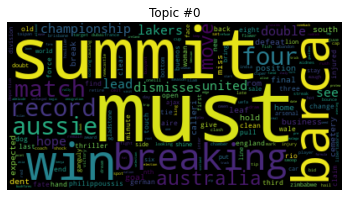

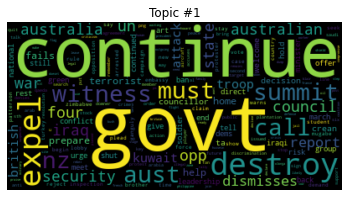

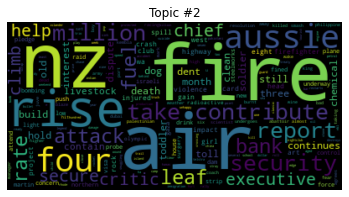

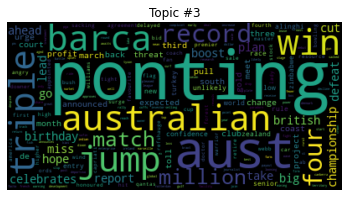

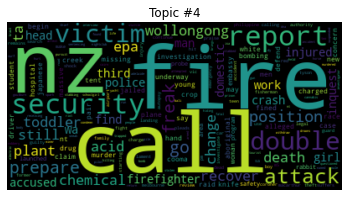

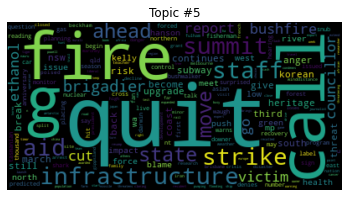

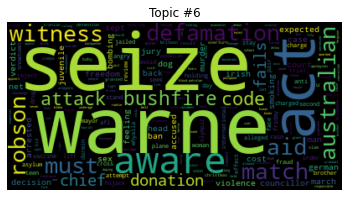

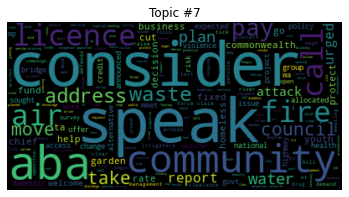

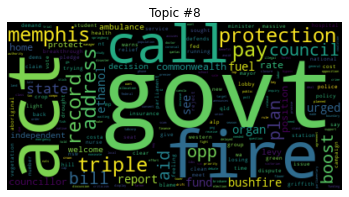

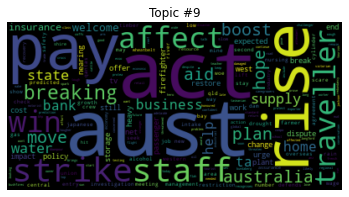

In [7]:
lda.print_topics()
perplexity=lda.compute_perplexity()
lda.plot_word_cloud(plt)

Below code still in test, haven't get run

In [ ]:
models=[]
perplexities=[]
models.append(lda)
perplexities.append(perplexity)
for topics in [20, 40, 60, 80, 100]:
    lda=LDA(documents=docs, vocabulary=dictionary, K=topics, max_iteration=1000)
    topic_prob_list=lda.execute()
    models.append(lda)
    perplexity=lda.compute_perplexity(self)
    perplexities.append(perplexity)

In [ ]:
topics=[10, 20, 40, 60, 80,100]
plt.plot(topics,perplexities,color="red",linewidth=2)
plt.xlabel("Number of Topic")
plt.ylabel("Perplexity")
plt.show()

In [ ]:
print(lda.documents_topics[1])
print(lda.documents_topics[2])
print(lda.topics_words)
print(np.sum(lda.topics_words,axis=1))
new_topic_matrixs=lda.topics_words/np.sum(lda.topics_words,axis=1,keepdims=True)
print(new_topic_matrixs)
index_matrix=(new_topic_matrixs.argsort())[:,-10:]
print(new_topic_matrixs[0,2615])
print(new_topic_matrixs[0,1530])
print(new_topic_matrixs[0,2202])
new_dict={v:k for k,v in vocabulary.items()}
# print(new_dict)

for i in range(index_matrix.shape[0]):
    strs=""
    print('topic '+'\n')
    for j in range(index_matrix.shape[1]):
        index=index_matrix[i][j]
        if j!=index_matrix.shape[1]-1:
            strs=strs+np.around(new_topic_matrixs[i][index],3).astype('str')+'*'+new_dict[index]+'+'
        else:
            strs=strs+np.around(new_topic_matrixs[i][index],3).astype('str')+'*'+new_dict[index]
    print(strs+'\n')
        

In [ ]:
topic_weights=lda.topics_words/np.sum(lda.topics_words,axis=1,keepdims=True)
# compute doc-topic probability
doc_topic_prob=lda.documents_topics/np.sum(lda.documents_topics,axis=1,keepdims=True)
prob_doc=0
doc_word_num=0
for i in range(lda.M):
    for index,word in enumerate(lda.documents[i]):
        prob_word=0
        for k in range(lda.K):
            prob_topic=doc_topic_prob[i][k]
            prob_topic_word=topic_weights[k][word]
            prob_word +=prob_topic*prob_topic_word
        prob_doc+= np.log(prob_word)
    doc_word_num+=len(lda.documents[i])

perplexity=np.exp(-prob_doc/doc_word_num)
print(perplexity)

In [ ]:
import collections
from wordcloud import WordCloud 
for topic in range(lda.K):
    data = []   
    text = ""
    topic_weights=lda.topics_words/np.sum(lda.topics_words,axis=1,keepdims=True)
    index_matrix=(topic_weights.argsort())[:,-10:]
    for i in range(len(lda.topics_words[topic])):
#         print(i)
        if lda.topics_words[topic][i]>1:
            data.append(new_dict[i]) 
    text = ' '.join(data)
    # Generate a word cloud image
    wordcloud = WordCloud().generate(text)  
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
#     plt.title("Topic #" + str(topic))
    plt.show()

In [ ]:
import gensim
dictionary = corpora.Dictionary(cleanedData)
# print(dictionary)
# print(cleanedData)
corpus = [dictionary.doc2bow(text) for text in cleanedData]
# print(corpus)
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           num_topics=10,
                                           id2word=dictionary)

In [ ]:
from pprint import pprint
pprint(lda_model.print_topics())

In [ ]:
docID=100
print(data[100])
print(cleanedData[100])
doc_bow = dictionary.doc2bow(cleanedData[100])
doc_lda = lda_model[doc_bow]
print(doc_bow)
doc_lda=sorted(doc_lda,key=lambda x:(x[1],x[0]),reverse=True)
print('Score:{}\t\n Topic:{}\n{}'.format(doc_lda[0][1], doc_lda[0][0],lda_model.print_topic(doc_lda[0][0])))